# ☕ Coffee Vending - EDA Notebook
**Purpose:** Professional, scalable EDA for coffee vending transactions.

## 1. Project configuration

In [2]:
from dataclasses import dataclass
from typing import Optional, Dict, List
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = False

def _norm_freq(freq: str | None) -> str:
    """Normaliza alias de frecuencia para pandas (minúsculas)."""
    return "h" if not freq else str(freq).lower()


@dataclass(slots=True)
class ProjectConfig:
    # Core
    timezone: str = "Europe/Kyiv"
    currency: str = "USD"
    default_freq: str = "h"
    save_dir: Path = Path("./artifacts")

    # Exogenous (requiere para clima/festivos)
    latitude: float = 50.4501        # Kyiv por defecto
    longitude: float = 30.5234
    country_code: str = "UA"         # ISO-2 para Nager.Date
    region_codes: list[str] | None = None  # e.g., ["UA-30"] si aplicara

    def __post_init__(self) -> None:
        # Normaliza frecuencia y asegura carpeta
        self.default_freq = _norm_freq(self.default_freq)
        self.save_dir = Path(self.save_dir)
        self.save_dir.mkdir(parents=True, exist_ok=True)

    @property
    def freq(self) -> str:
        """Frecuencia normalizada para usar en Grouper/date_range."""
        return _norm_freq(self.default_freq)

@dataclass
class ColumnsConfig:
    date_col: str = "date"
    datetime_col: str = "datetime"
    product_col: str = "coffee_name"
    amount_col: str = "money"
    qty_col: str = None
    payment_col: str = "cash_type"
    machine_id_col: str = None
    store_id_col: str = None



@dataclass
class PathsConfig:
    raw_csv_path: Path = Path("../data/raw/index_1.csv")
    cache_parquet_path: Path = Path("../data/raw/index_1.parquet")
    clean_csv_path: Path = Path("../data/clean/index_1.csv")
    data_dict_path: Path = Path("../data/clean/data_dict.csv")

PROJ = ProjectConfig()
COLS = ColumnsConfig()
PATHS = PathsConfig()

PROJ.save_dir.mkdir(parents=True, exist_ok=True)

print("Configs loaded.")
print(PROJ)
print(COLS)
print(PATHS)


Configs loaded.
ProjectConfig(timezone='Europe/Kyiv', currency='USD', default_freq='h', save_dir=WindowsPath('artifacts'), latitude=50.4501, longitude=30.5234, country_code='UA', region_codes=None)
ColumnsConfig(date_col='date', datetime_col='datetime', product_col='coffee_name', amount_col='money', qty_col=None, payment_col='cash_type', machine_id_col=None, store_id_col=None)
PathsConfig(raw_csv_path=WindowsPath('../data/raw/index_1.csv'), cache_parquet_path=WindowsPath('../data/raw/index_1.parquet'), clean_csv_path=WindowsPath('../data/clean/index_1.csv'), data_dict_path=WindowsPath('../data/clean/data_dict.csv'))


## 2. Data loading and schema checks

In [3]:
def load_data(paths: PathsConfig) -> pd.DataFrame:
    if paths.cache_parquet_path.exists():
        df = pd.read_parquet(paths.cache_parquet_path)
        print(f"Loaded Parquet: {paths.cache_parquet_path}")
        return df
    if paths.raw_csv_path.exists():
        df = pd.read_csv(paths.raw_csv_path)
        print(f"Loaded CSV: {paths.raw_csv_path}")
        return df
    raise FileNotFoundError("No data file found. Update PathsConfig.")

def expected_schema(cols: ColumnsConfig) -> Dict[str, str]:
    return {
        cols.date_col: "date-like",
        cols.datetime_col: "datetime-like",
        cols.product_col: "string-like",
        cols.qty_col: "numeric",
        cols.amount_col: "numeric",
        cols.payment_col: "string-like",
        cols.machine_id_col: "string-like",
        cols.store_id_col: "string-like",
    }

def check_schema(df: pd.DataFrame, cols: ColumnsConfig) -> pd.DataFrame:
    exp = expected_schema(cols)
    rows = []
    for col, exp_type in exp.items():
        exists = col in df.columns
        inferred = str(df[col].dtype) if exists else "MISSING"
        rows.append({
            "column": col,
            "exists": exists,
            "expected": exp_type,
            "inferred_dtype": inferred
        })
    report = pd.DataFrame(rows)
    return report

df_raw = load_data(PATHS)
schema_report = check_schema(df_raw, COLS)
display(schema_report)
df_raw.head(3)

Loaded CSV: ..\data\raw\index_1.csv


,column,exists,expected,inferred_dtype
0,date,True,date-like,object
1,datetime,True,datetime-like,object
2,coffee_name,True,string-like,object
3,None,False,string-like,MISSING
4,money,True,numeric,float64
5,cash_type,True,string-like,object


,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate


## 3. Cleaning: dtypes, timezone, duplicates, missingness

In [5]:
def coerce_datetime(df: pd.DataFrame, cols: ColumnsConfig, timezone: str) -> pd.DataFrame:
    df = df.copy()
    if cols.datetime_col in df.columns:
        df[cols.datetime_col] = pd.to_datetime(df[cols.datetime_col], errors="coerce", utc=True)
        df[cols.datetime_col] = df[cols.datetime_col].dt.tz_convert(timezone)
    if cols.date_col in df.columns:
        df[cols.date_col] = pd.to_datetime(df[cols.date_col], errors="coerce").dt.date
    return df

def standardize_types(df: pd.DataFrame, cols: ColumnsConfig) -> pd.DataFrame:
    df = df.copy()
    if cols.product_col in df.columns:
        df[cols.product_col] = df[cols.product_col].astype("string")
    if cols.payment_col in df.columns:
        df[cols.payment_col] = df[cols.payment_col].astype("string")
    for num_col in [cols.qty_col, cols.amount_col]:
        if num_col in df.columns:
            df[num_col] = pd.to_numeric(df[num_col], errors="coerce")
    for cat_col in [cols.machine_id_col, cols.store_id_col]:
        if cat_col in df.columns:
            df[cat_col] = df[cat_col].astype("string")
    return df

def drop_strict_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    before = len(df)
    df = df.drop_duplicates()
    print(f"Dropped {before - len(df)} exact duplicates.")
    return df

def missing_report(df: pd.DataFrame) -> pd.DataFrame:
    total = len(df)
    rep = (
        df.isna().sum()
        .rename("missing_count")
        .to_frame()
        .assign(missing_pct=lambda x: 100 * x["missing_count"] / total)
        .sort_values("missing_pct", ascending=False)
    )
    return rep

df = coerce_datetime(df_raw, COLS, PROJ.timezone)
df = standardize_types(df, COLS)
df = drop_strict_duplicates(df)

display(missing_report(df).head(20))
df.head(3)

Dropped 0 exact duplicates.


,missing_count,missing_pct
card,89,2.447745
date,0,0.000000
datetime,0,0.000000
cash_type,0,0.000000
money,0,0.000000
coffee_name,0,0.000000


,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 12:15:50.520000+02:00,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 14:19:22.539000+02:00,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 14:20:18.089000+02:00,card,ANON-0000-0000-0002,38.7,Hot Chocolate


## 4. Feature engineering: time features and canonical granularities

In [6]:
def add_time_features(df: pd.DataFrame, cols: ColumnsConfig) -> pd.DataFrame:
    df = df.copy()
    if cols.datetime_col not in df.columns:
        raise KeyError(f"Missing {cols.datetime_col}.")
    s = df[cols.datetime_col]
    df["year"] = s.dt.year
    df["month"] = s.dt.month
    df["day"] = s.dt.day
    df["hour"] = s.dt.hour
    df["dow"] = s.dt.dayofweek
    df["week"] = s.dt.isocalendar().week.astype(int)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12.0)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12.0)
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24.0)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24.0)
    return df

def ensure_sorted(df: pd.DataFrame, cols: ColumnsConfig) -> pd.DataFrame:
    return df.sort_values(by=[cols.datetime_col]).reset_index(drop=True)

def make_canonical_series(df: pd.DataFrame, cols: ColumnsConfig, freq: str = "H") -> pd.DataFrame:
    s = df[cols.datetime_col]
    idx = pd.date_range(start=s.min().floor(freq), end=s.max().ceil(freq), freq=freq, tz=s.dt.tz)
    base = pd.DataFrame({cols.datetime_col: idx})
    return base

df = add_time_features(df, COLS)
df = ensure_sorted(df, COLS)
canonical = make_canonical_series(df, COLS, freq=PROJ.default_freq)
df.head(3)


,date,datetime,cash_type,card,money,coffee_name,year,month,day,hour,dow,week,month_sin,month_cos,hour_sin,hour_cos
0,2024-03-01,2024-03-01 12:15:50.520000+02:00,card,ANON-0000-0000-0001,38.7,Latte,2024,3,1,12,4,9,1.0,6.123234e-17,1.224647e-16,-1.000000
1,2024-03-01,2024-03-01 14:19:22.539000+02:00,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,14,4,9,1.0,6.123234e-17,-5.000000e-01,-0.866025
2,2024-03-01,2024-03-01 14:20:18.089000+02:00,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,14,4,9,1.0,6.123234e-17,-5.000000e-01,-0.866025


## 5. Aggregations: hourly, daily, product, payment

In [7]:
import pandas as pd
import numpy as np
from math import ceil, floor

def _norm_freq(freq: str | None) -> str:
    """Normalize pandas offset alias to lowercase. Default hourly."""
    return "h" if not freq else str(freq).lower()


def aggregate_transactions(
    df: pd.DataFrame,
    cols,
    freq: str | None = None,
    include_full_grid: bool = True,
) -> pd.DataFrame:
    """Sum `money` and count transactions by time. Fill missing periods with zeros."""
    use_freq = _norm_freq(freq)

    if cols.datetime_col not in df.columns:
        raise KeyError(f"Missing datetime column: {cols.datetime_col}")
    if cols.amount_col not in df.columns:
        raise KeyError(f"Missing amount column: {cols.amount_col}")

    tmp = df[[cols.datetime_col, cols.amount_col]].copy()
    tmp[cols.datetime_col] = pd.to_datetime(tmp[cols.datetime_col], errors="coerce")
    tmp[cols.amount_col] = pd.to_numeric(tmp[cols.amount_col], errors="coerce")
    tmp = tmp.dropna(subset=[cols.datetime_col])

    g = tmp.groupby(pd.Grouper(key=cols.datetime_col, freq=use_freq), dropna=False)
    out = pd.DataFrame({
        cols.amount_col: g[cols.amount_col].sum(min_count=1),
        "transactions": g.size()
    })

    if include_full_grid and not out.empty:
        s = tmp[cols.datetime_col]
        tz = getattr(s.dt, "tz", None)
        # use lowercase everywhere to avoid FutureWarning
        lo = s.min().floor(use_freq)
        hi = s.max().ceil(use_freq)
        idx = pd.date_range(lo, hi, freq=use_freq, tz=tz)
        out = out.reindex(idx)

    out[cols.amount_col] = out[cols.amount_col].fillna(0.0)
    out["transactions"] = out["transactions"].fillna(0).astype(int)

    out = out.reset_index().rename(columns={"index": cols.datetime_col})
    out = out.sort_values(cols.datetime_col).reset_index(drop=True)
    return out


def aggregate_by_category(
    df: pd.DataFrame,
    cols,
    category_col: str,
    freq: str = "D",
    include_full_grid: bool = True,
) -> pd.DataFrame:
    """Sum `money` and count transactions by time and category. Fill missing cells with zeros."""
    use_freq = _norm_freq(freq)

    for c in [cols.datetime_col, category_col, cols.amount_col]:
        if c not in df.columns:
            raise KeyError(f"Missing required column: {c}")

    tmp = df[[cols.datetime_col, category_col, cols.amount_col]].copy()
    tmp[cols.datetime_col] = pd.to_datetime(tmp[cols.datetime_col], errors="coerce")
    tmp[cols.amount_col] = pd.to_numeric(tmp[cols.amount_col], errors="coerce")
    tmp = tmp.dropna(subset=[cols.datetime_col])

    g = tmp.groupby([pd.Grouper(key=cols.datetime_col, freq=use_freq), category_col], dropna=False)
    agg_sum = g[cols.amount_col].sum(min_count=1).rename(cols.amount_col)
    agg_cnt = g.size().rename("transactions")
    out = pd.concat([agg_sum, agg_cnt], axis=1)

    if include_full_grid and not out.empty:
        s = tmp[cols.datetime_col]
        tz = getattr(s.dt, "tz", None)
        lo = s.min().floor(use_freq)
        hi = s.max().ceil(use_freq)
        time_idx = pd.date_range(lo, hi, freq=use_freq, tz=tz)
        cats = pd.Index(sorted(tmp[category_col].dropna().unique()), name=category_col)
        full_index = pd.MultiIndex.from_product([time_idx, cats], names=[cols.datetime_col, category_col])
        out = out.reindex(full_index)

    out[cols.amount_col] = out[cols.amount_col].fillna(0.0)
    out["transactions"] = out["transactions"].fillna(0).astype(int)

    out = out.reset_index().sort_values([cols.datetime_col, category_col]).reset_index(drop=True)
    return out


ts_hourly = aggregate_transactions(df, COLS, freq="h")
ts_daily  = aggregate_transactions(df, COLS, freq="D")

by_product_daily = aggregate_by_category(df, COLS, category_col=COLS.product_col, freq="D")
by_payment_daily = aggregate_by_category(df, COLS, category_col="cash_type", freq="D")

## 6. Plot analysis

In [8]:
DT_COL = COLS.datetime_col          # "datetime"
Y_COL  = COLS.amount_col            # "money"
PROD_COL = COLS.product_col         # "coffee_name"

def ensure_dt_local(df: pd.DataFrame, dt_col: str = DT_COL) -> pd.DataFrame:
    d = df.copy()
    d[dt_col] = pd.to_datetime(d[dt_col], errors="coerce")
    d = d.dropna(subset=[dt_col]).sort_values(dt_col)
    d = d.rename(columns={dt_col: "dt_local"})
    return d

def weekday_labels(lang: str = "es") -> list[str]:
    return ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"] if lang=="es" else ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

def _pick_series_col(df: pd.DataFrame) -> str:
    if Y_COL in df.columns and pd.api.types.is_numeric_dtype(df[Y_COL]): 
        return Y_COL
    raise KeyError(f"No numeric target found. Expected: {Y_COL}")

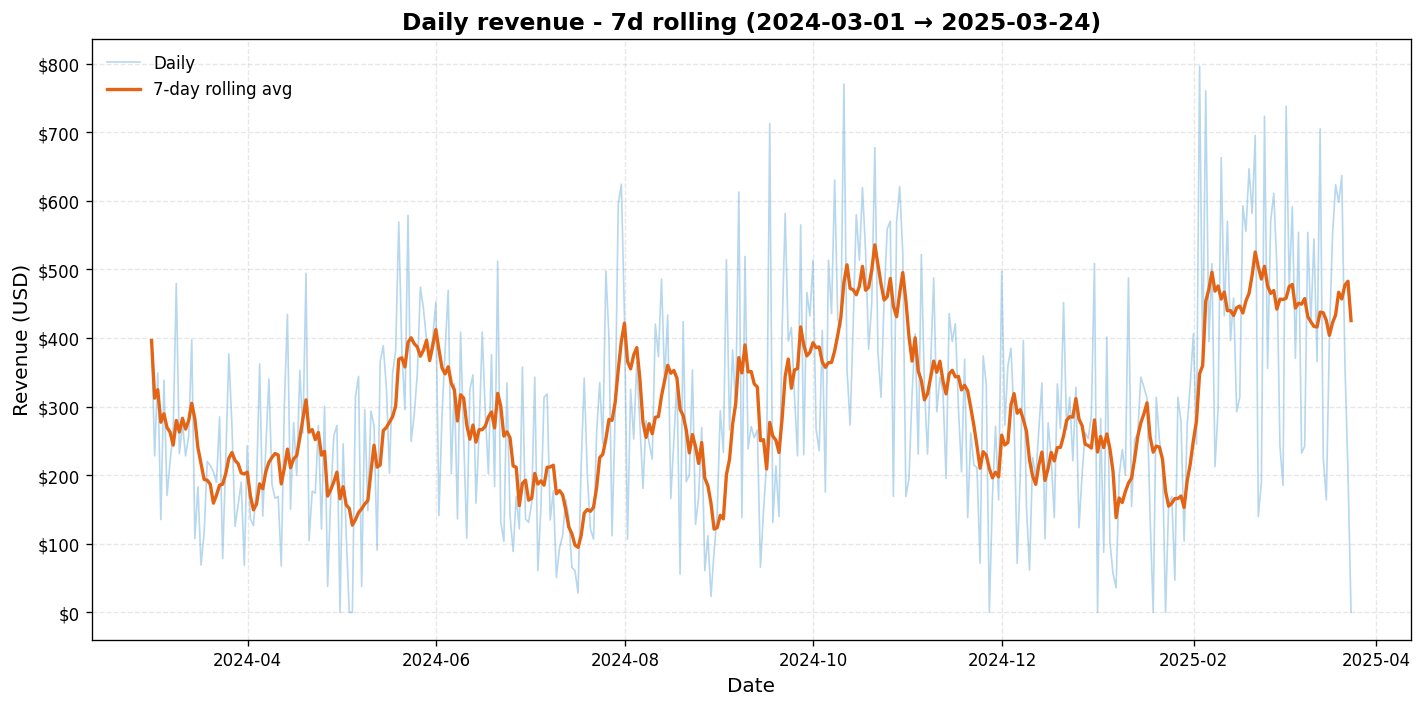

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

def plot_series(df, y, window=7, title="Time series", currency="USD"):
    # Calcular rolling
    df = df.copy()
    df[f"{y}_roll"] = df[y].rolling(window=window, min_periods=1).mean()

    fig, ax = plt.subplots(figsize=(12, 6))

    # Serie original
    ax.plot(df["datetime"], df[y],
            label="Daily",
            color="#4B9CD3",
            alpha=0.4,
            linewidth=1)

    # Rolling
    ax.plot(df["datetime"], df[f"{y}_roll"],
            label=f"{window}-day rolling avg",
            color="#E36414",
            linewidth=2)

    # Formato eje Y como moneda
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}" if currency=="USD" else "{x:,.0f}"))

    # Formato eje X como fechas
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    # Títulos y estilos
    ax.set_title(f"{title} ({df['datetime'].min().date()} → {df['datetime'].max().date()})", fontsize=14, weight="bold")
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel(f"Revenue ({currency})", fontsize=12)
    ax.grid(True, which="major", linestyle="--", alpha=0.3)

    # Leyenda optimizada
    ax.legend(frameon=False, loc="upper left")

    plt.tight_layout()
    plt.show()

# Ejemplo
plot_series(ts_daily, y="money", window=7, title="Daily revenue - 7d rolling", currency="USD")


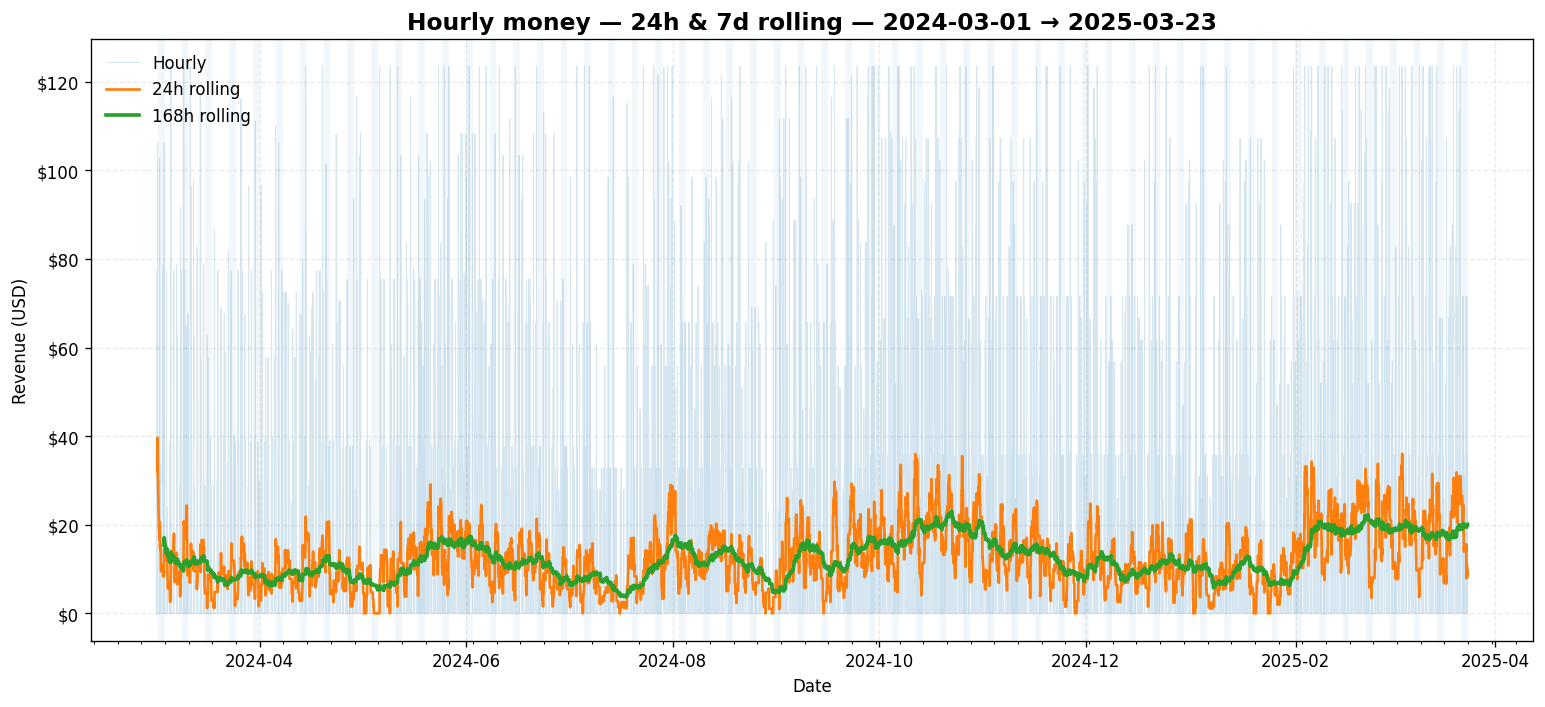

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from datetime import timedelta

def plot_hourly_money(ts_hourly: pd.DataFrame,
                      y: str = "money",
                      dt_col: str = "datetime",
                      roll1: int = 24,            # 24h
                      roll2: int = 24*7,          # 7 días
                      title: str = "Hourly revenue",
                      currency: str = "USD",
                      show_weekends: bool = True,
                      cap_p99: bool = True,       # recorta picos > p99 para que no aplasten
                      window_min_frac: float = 1/3):
    """Plot horario con 2 suavizados (24h y 7d), formato de moneda y sombreado de fines de semana."""
    d = ts_hourly[[dt_col, y]].copy()
    d[dt_col] = pd.to_datetime(d[dt_col], errors="coerce")
    d[y] = pd.to_numeric(d[y], errors="coerce")
    d = d.dropna(subset=[dt_col]).sort_values(dt_col)
    d = d.set_index(dt_col)

    if d.empty:
        print("No hourly data.")
        return

    # Rolling windows
    roll1 = max(2, int(roll1))
    roll2 = max(2, int(roll2))
    r1 = d[y].rolling(roll1, min_periods=max(1, int(roll1*window_min_frac))).mean()
    r2 = d[y].rolling(roll2, min_periods=max(1, int(roll2*window_min_frac))).mean()

    # Opcional: limitar picos para la escala
    y_plot = d[y].copy()
    if cap_p99 and np.isfinite(y_plot).any():
        p99 = np.nanpercentile(y_plot.values, 99)
        y_plot = np.clip(y_plot, None, p99)

    fig, ax = plt.subplots(figsize=(13, 6))

    # Serie cruda (muy tenue)
    ax.plot(d.index, y_plot.values, alpha=0.18, linewidth=0.6, label="Hourly")

    # Rolling 24h (línea media)
    ax.plot(r1.index, r1.values, linewidth=1.6, label=f"{roll1}h rolling")

    # Rolling 7d (tendencia de fondo)
    ax.plot(r2.index, r2.values, linewidth=2.2, label=f"{roll2}h rolling")

    # Formato eje Y como moneda
    if currency.upper() == "USD":
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))
    else:
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    # Eje X: meses como major, semanas como minor
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))

    # Sombrear fines de semana para lectura intradía
    if show_weekends:
        start = d.index.min().normalize()
        end = d.index.max().normalize()
        day = pd.date_range(start, end, freq="D", tz=d.index.tz)
        for t in day:
            if t.weekday() >= 5:  # 5=Sat, 6=Sun
                ax.axvspan(t, t + timedelta(days=1), alpha=0.06)

    # Títulos y ejes
    lo, hi = d.index.min(), d.index.max()
    ax.set_title(f"{title} — {lo.date()} → {hi.date()}", fontsize=14, weight="bold")
    ax.set_xlabel("Date")
    ax.set_ylabel(f"Revenue ({currency})")
    ax.grid(True, which="major", linestyle="--", alpha=0.25)
    ax.legend(loc="upper left", frameon=False)

    plt.tight_layout()
    plt.show()

plot_hourly_money(ts_hourly, y="money",
                  title="Hourly money — 24h & 7d rolling",
                  currency="USD",
                  show_weekends=True,
                  cap_p99=True)

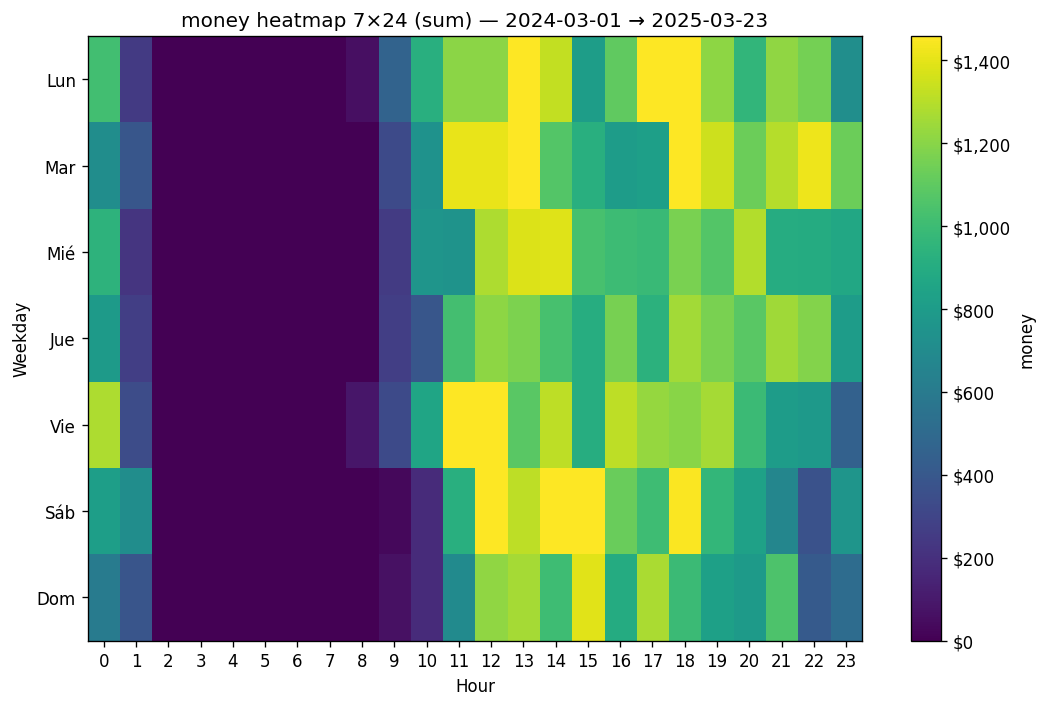

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


def plot_hour_dow_heatmap_pretty(
    df_hourly: pd.DataFrame,
    y: str = "money",
    dt_col: str = "datetime",
    aggfunc: str = "sum",              # 'sum' | 'mean' | 'median'
    title: str | None = None,
    lang: str = "es",                  # 'es' o 'en'
    currency: str = "USD",
    annotate: bool = False,            # por defecto OFF: más limpio
    annotation_fmt: str = ".0f",
    show_zeros_as_blank: bool = True,
    vmin_pct: float = 5.0,             # recorte robusto (percentiles)
    vmax_pct: float = 95.0
) -> None:
    """
    Heatmap 7x24 legible: escala robusta, orden Mon→Sun, colorbar con moneda.
    """
    # ---------- prep ----------
    d = df_hourly[[dt_col, y]].copy()
    d[dt_col] = pd.to_datetime(d[dt_col], errors="coerce")
    d[y] = pd.to_numeric(d[y], errors="coerce")
    d = d.dropna(subset=[dt_col, y]).sort_values(dt_col)
    if d.empty:
        print("Empty heatmap.")
        return

    # Deriva hora y día de semana
    d["hour"] = d[dt_col].dt.hour
    d["dow"] = d[dt_col].dt.dayofweek  # 0=Mon .. 6=Sun

    agg = aggfunc if aggfunc in {"sum", "mean", "median"} else "sum"
    mat = (
        d.pivot_table(index="dow", columns="hour", values=y, aggfunc=agg, observed=False)
         .reindex(index=range(7), columns=range(24))
    )

    Z = mat.to_numpy(dtype=float)
    if Z.size == 0 or np.all(np.isnan(Z)):
        print("Empty heatmap.")
        return

    # ---------- escala robusta ----------
    finite = Z[np.isfinite(Z)]
    if finite.size:
        vmin = np.nanpercentile(finite, vmin_pct)
        vmax = np.nanpercentile(finite, vmax_pct)
        if vmin >= vmax:  # fallback
            vmin, vmax = np.nanmin(finite), np.nanmax(finite)
    else:
        vmin, vmax = None, None

    # ---------- plot ----------
    plt.figure(figsize=(9, 6))
    # Usamos origin='upper' para que Lunes quede arriba
    im = plt.imshow(Z, aspect="auto", origin="upper", vmin=vmin, vmax=vmax)

    # Colorbar con moneda
    cbar = plt.colorbar(im)
    if currency.upper() == "USD":
        cbar.formatter = mtick.StrMethodFormatter("${x:,.0f}")
    else:
        cbar.formatter = mtick.StrMethodFormatter("{x:,.0f}")
    cbar.update_ticks()
    cbar.set_label(y, rotation=90)

    # Títulos y ejes
    start, end = d[dt_col].min().date(), d[dt_col].max().date()
    plt.title(title or f"{y} heatmap 7×24 ({agg}) — {start} → {end}")
    plt.xlabel("Hour")
    plt.ylabel("Weekday")

    # Etiquetas ordenadas L→D
    wk_es = ["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"]
    wk_en = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    ylabels = wk_es if lang == "es" else wk_en
    plt.xticks(ticks=np.arange(24), labels=list(range(24)))
    plt.yticks(ticks=np.arange(7), labels=ylabels)

    # ---------- anotaciones (opcionales) ----------
    if annotate:
        # Umbral para color de texto
        thr = np.nanmean(finite) if finite.size else 0.0
        for i in range(Z.shape[0]):
            for j in range(Z.shape[1]):
                val = Z[i, j]
                if np.isnan(val):
                    continue
                if show_zeros_as_blank and np.isclose(val, 0.0):
                    continue
                txt = format(val, annotation_fmt)
                color = "white" if val >= thr else "black"
                plt.text(j, i, txt, ha="center", va="center", fontsize=8, color=color)

    plt.tight_layout()
    plt.show()

plot_hour_dow_heatmap_pretty(
    ts_hourly,           # tu serie por hora
    y="money",
    dt_col="datetime",
    aggfunc="sum",
    lang="es",
    currency="USD",
    annotate=False,          # pon True si de verdad necesitas números en cada celda
    vmin_pct=5, vmax_pct=95  # quita el efecto de outliers
)

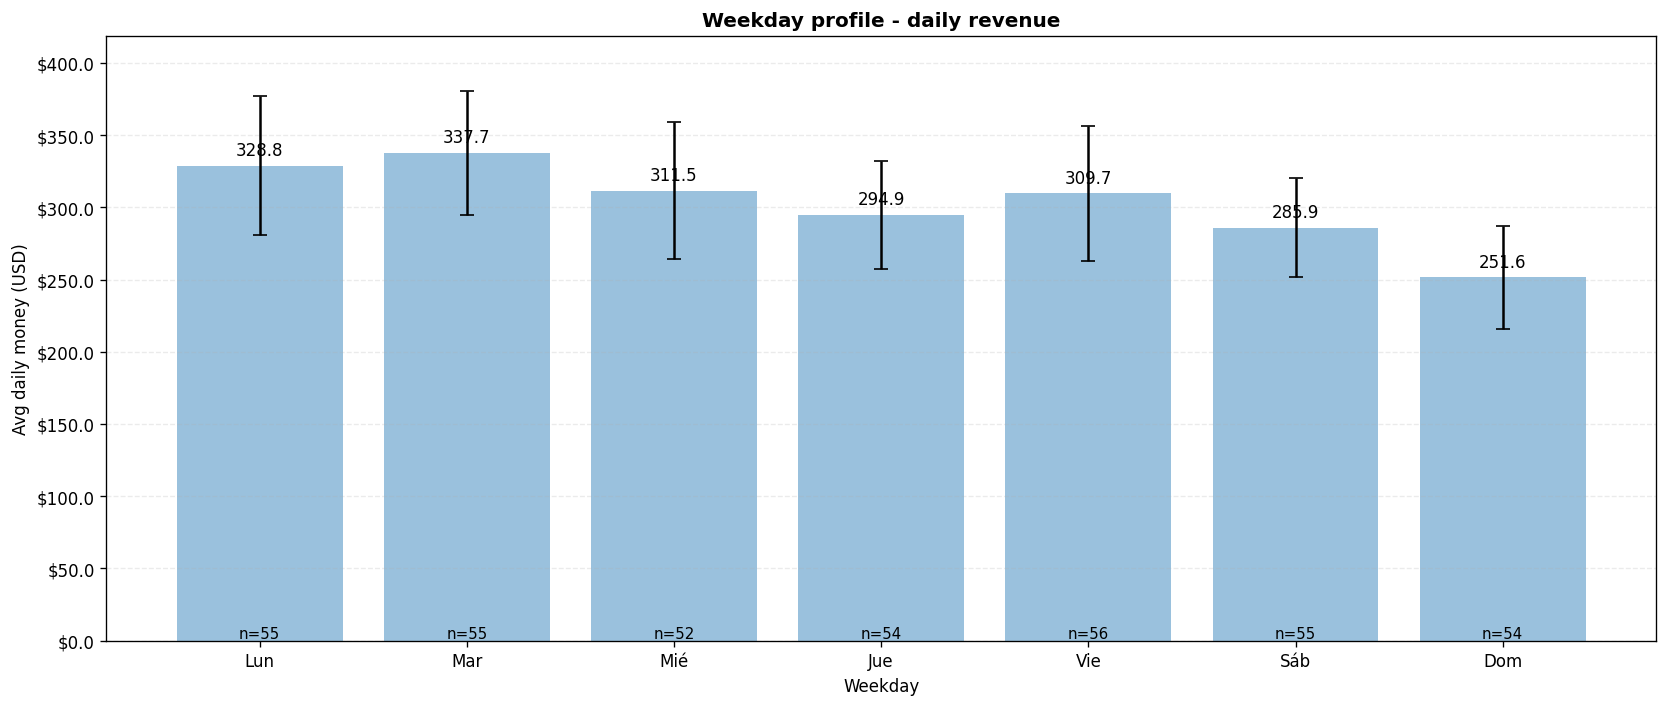

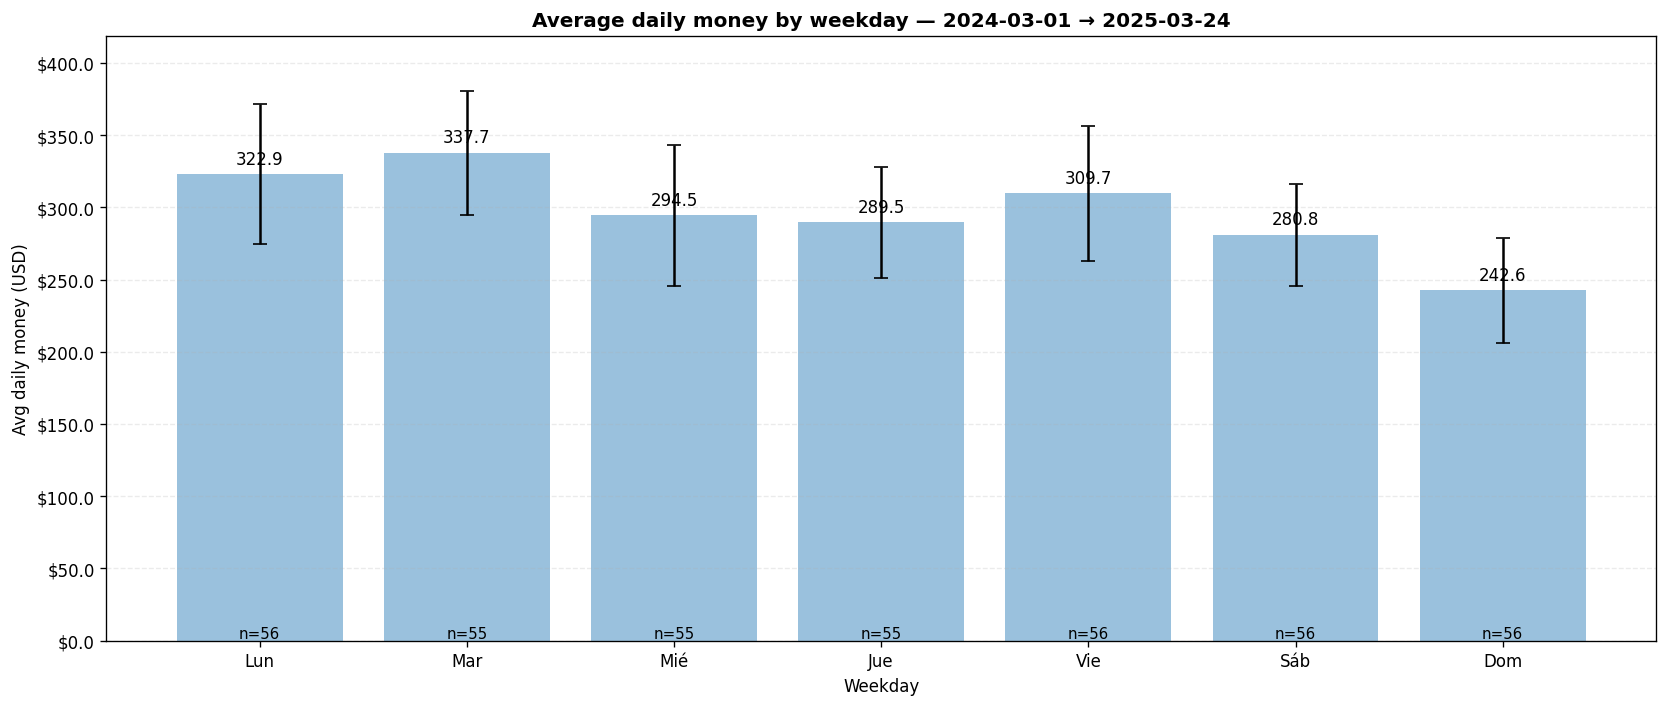

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def weekday_labels(lang: str = "es"):
    return ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"] if lang=="es" else ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

def plot_weekday_profile_daily(df: pd.DataFrame,
                               y: str = "money",
                               dt_col: str = "datetime",
                               lang: str = "es",
                               currency: str = "USD",
                               show_ci: bool = True,
                               ci_mode: str = "ci95",   # 'std' | 'sem' | 'ci95' | 'none'
                               decimals: int = 1,       # nº de decimales en ticks y labels
                               show_n: bool = True,     # mostrar n días por barra
                               title: str | None = None):
    # ---- preparar serie diaria ----
    d = df[[dt_col, y]].copy()
    d[dt_col] = pd.to_datetime(d[dt_col], errors="coerce")
    d[y] = pd.to_numeric(d[y], errors="coerce")
    d = d.dropna(subset=[dt_col]).sort_values(dt_col)
    daily = d.set_index(dt_col)[y].resample("D").sum(min_count=1)

    # ---- estadísticos por día de semana ----
    dow = daily.groupby(daily.index.dayofweek)
    mean = dow.mean().reindex(range(7))
    cnt  = dow.count().reindex(range(7)).fillna(0)
    err = None
    if show_ci and ci_mode.lower() != "none":
        std = dow.std().reindex(range(7)).fillna(0.0)
        if ci_mode.lower() == "std":
            err = std
        elif ci_mode.lower() == "sem":
            err = std / np.sqrt(cnt.replace(0, np.nan))
        else:  # ci95
            err = 1.96 * std / np.sqrt(cnt.replace(0, np.nan))
        err = err.fillna(0.0)

    # ---- plot ----
    x = np.arange(7)
    fig, ax = plt.subplots(figsize=(14, 6))

    if err is not None:
        ax.bar(x, mean.values, yerr=err.values, alpha=0.45, capsize=4, linewidth=0.6)
    else:
        ax.bar(x, mean.values, alpha=0.45)

    ax.set_xticks(x, weekday_labels(lang))
    ax.set_xlabel("Weekday")

    # Formato moneda con decimales
    fmt = "${x:,.%df}" % decimals if currency.upper()=="USD" else "{x:,.%df}" % decimals
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
    ax.set_ylabel(f"Avg daily {y} ({currency})")

    if title is None:
        start, end = daily.index.min().date(), daily.index.max().date()
        title = f"Average daily {y} by weekday — {start} → {end}"
    ax.set_title(title, fontweight="bold")

    # Dejar aire arriba para etiquetas
    top = (mean + (err if err is not None else 0)).max()
    ax.set_ylim(0, float(top) * 1.10)

    # Etiquetas encima de cada barra (con decimales)
    for xi, v in enumerate(mean.values):
        if np.isfinite(v):
            ax.text(xi, v + 0.012*top, f"{v:,.{decimals}f}",
                    ha="center", va="bottom", fontsize=10)
            if show_n:
                ax.text(xi, 0, f"n={int(cnt.values[xi])}",
                        ha="center", va="bottom", fontsize=9)

    ax.grid(True, axis="y", linestyle="--", alpha=0.25)
    fig.tight_layout()
    plt.show()

plot_weekday_profile_daily(df, y="money", dt_col="datetime",
                           lang="es", currency="USD",
                           show_ci=True, ci_mode="ci95",
                           title="Weekday profile - daily revenue")

plot_weekday_profile_daily(ts_daily.rename(columns={"datetime":"datetime"}),  # si tu col ya se llama igual, omite rename
                           y="money", dt_col="datetime",
                           lang="es", currency="USD")

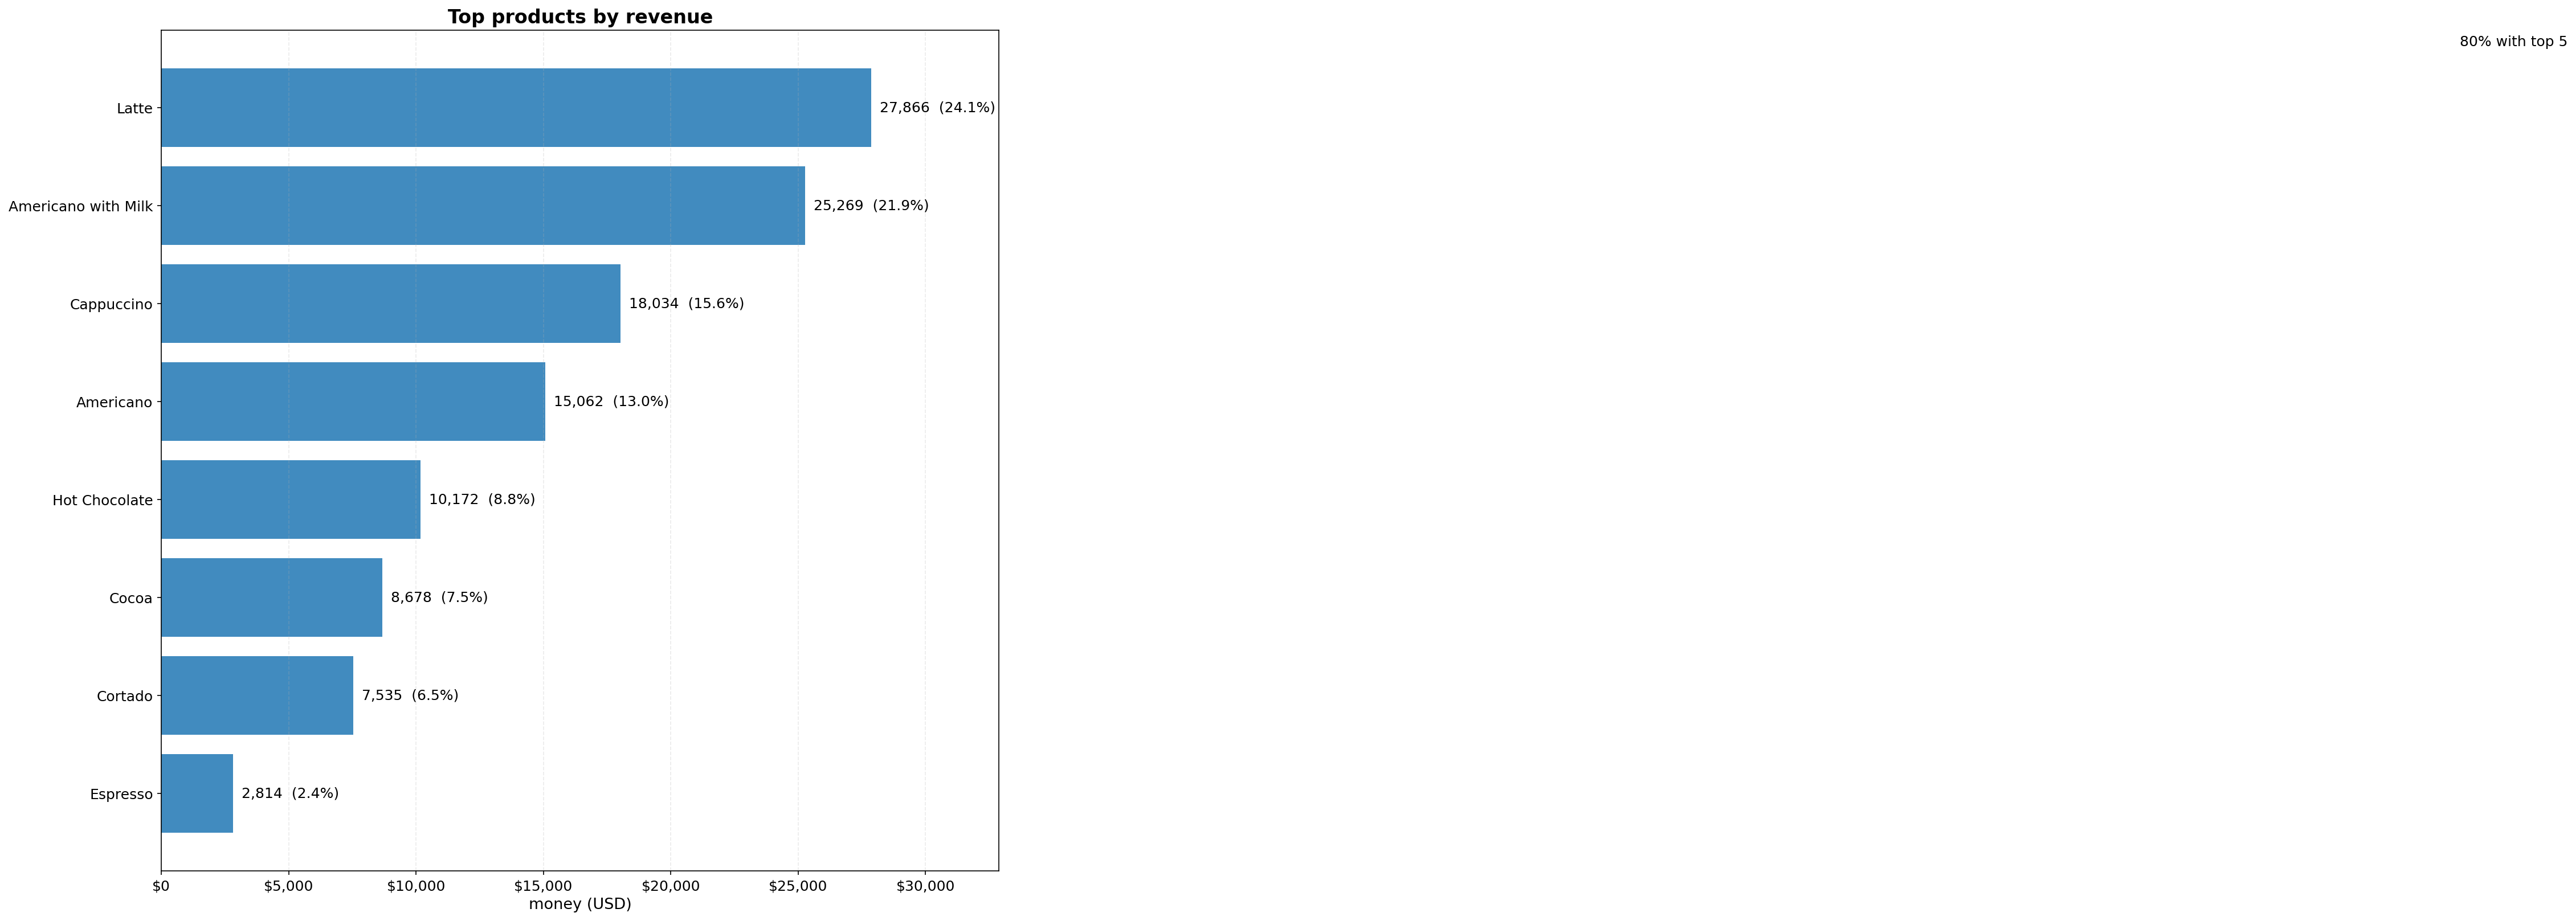

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from textwrap import shorten
import pandas as pd

def plot_top_products_bar_pretty(
    df: pd.DataFrame,
    product_col: str = "coffee_name",
    y: str = "money",
    top_n: int = 12,
    currency: str = "USD",
    decimals: int = 0,
    show_share: bool = True,
    show_values: bool = True,
    pareto: bool = True,
    pareto_threshold: float = 0.80,
    max_label_len: int = 36,
    title: str | None = None,
    # ---- nuevos parámetros de tamaño/estética ----
    fig_width: float = 18.0,      # ancho en pulgadas
    bar_height: float = 0.70,     # alto por barra (pulgadas)
    min_height: float = 6.0,      # alto mínimo
    max_height: float = 24.0,     # alto máximo
    left_margin: float = 0.28,    # margen izq. (0..1) para etiquetas largas
    dpi: int = 150,
    fontsize_title: int = 16,
    fontsize_tick: int = 12,
    fontsize_label: int = 13,
    annotation_fontsize: int = 12,
):
    if product_col not in df.columns or y not in df.columns:
        raise KeyError(f"Columns not found: {product_col}, {y}")

    g = (df.groupby(product_col, observed=False)[y]
           .sum(min_count=1)
           .sort_values(ascending=False))
    if g.empty:
        print("No data.")
        return

    g = g.iloc[:top_n]
    total = float(g.sum())
    share = g / total
    cum_share = share.cumsum()

    # Altura dinámica
    height = float(np.clip(bar_height * len(g) + 1.0, min_height, max_height))
    fig, ax = plt.subplots(figsize=(14, 12), dpi=dpi)
    fig.subplots_adjust(left=left_margin, right=0.98, top=0.90, bottom=0.08)

    y_pos = np.arange(len(g))
    ax.barh(y_pos, g.values, alpha=0.85)

    labels = [shorten(str(s), width=max_label_len, placeholder="…") for s in g.index]
    ax.set_yticks(y_pos, labels)
    ax.invert_yaxis()  # top arriba

    # Eje X en moneda
    fmt = "${x:,.%df}" % decimals if currency.upper() == "USD" else "{x:,.%df}" % decimals
    ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
    ax.set_xlabel(f"{y} ({currency})", fontsize=fontsize_label)
    ax.tick_params(axis="both", labelsize=fontsize_tick)

    if title is None:
        title = f"Top {len(g)} products by {y}"
    ax.set_title(title, fontweight="bold", fontsize=fontsize_title)

    ax.grid(True, axis="x", linestyle="--", alpha=0.25)

    max_v = float(g.max())
    ax.set_xlim(0, max_v * 1.18)

    # Anotaciones
    for i, v in enumerate(g.values):
        x_txt = v + max_v * 0.012
        pieces = []
        if show_values:
            pieces.append(f"{v:,.{decimals}f}")
        if show_share:
            pieces.append(f"({share.values[i]:.1%})")
        if pieces:
            ax.text(x_txt, i, "  ".join(pieces),
                    va="center", ha="left", fontsize=annotation_fontsize)

    # Línea Pareto
    if pareto and total > 0:
        x_p = pareto_threshold * total
        ax.axvline(x_p, linestyle="--", linewidth=1.2)
        k = int(np.searchsorted(cum_share.values, pareto_threshold) + 1)
        ax.text(x_p, -0.6, f"{int(pareto_threshold*100)}% with top {k}",
                ha="center", va="bottom", fontsize=fontsize_tick)

    plt.show()


plot_top_products_bar_pretty(
    df,
    product_col=COLS.product_col,   # "coffee_name"
    y=COLS.amount_col,              # "money"
    top_n=10,
    currency=PROJ.currency,         # "USD"
    decimals=0,
    pareto=True,
    pareto_threshold=0.80,
    title="Top products by revenue"
)

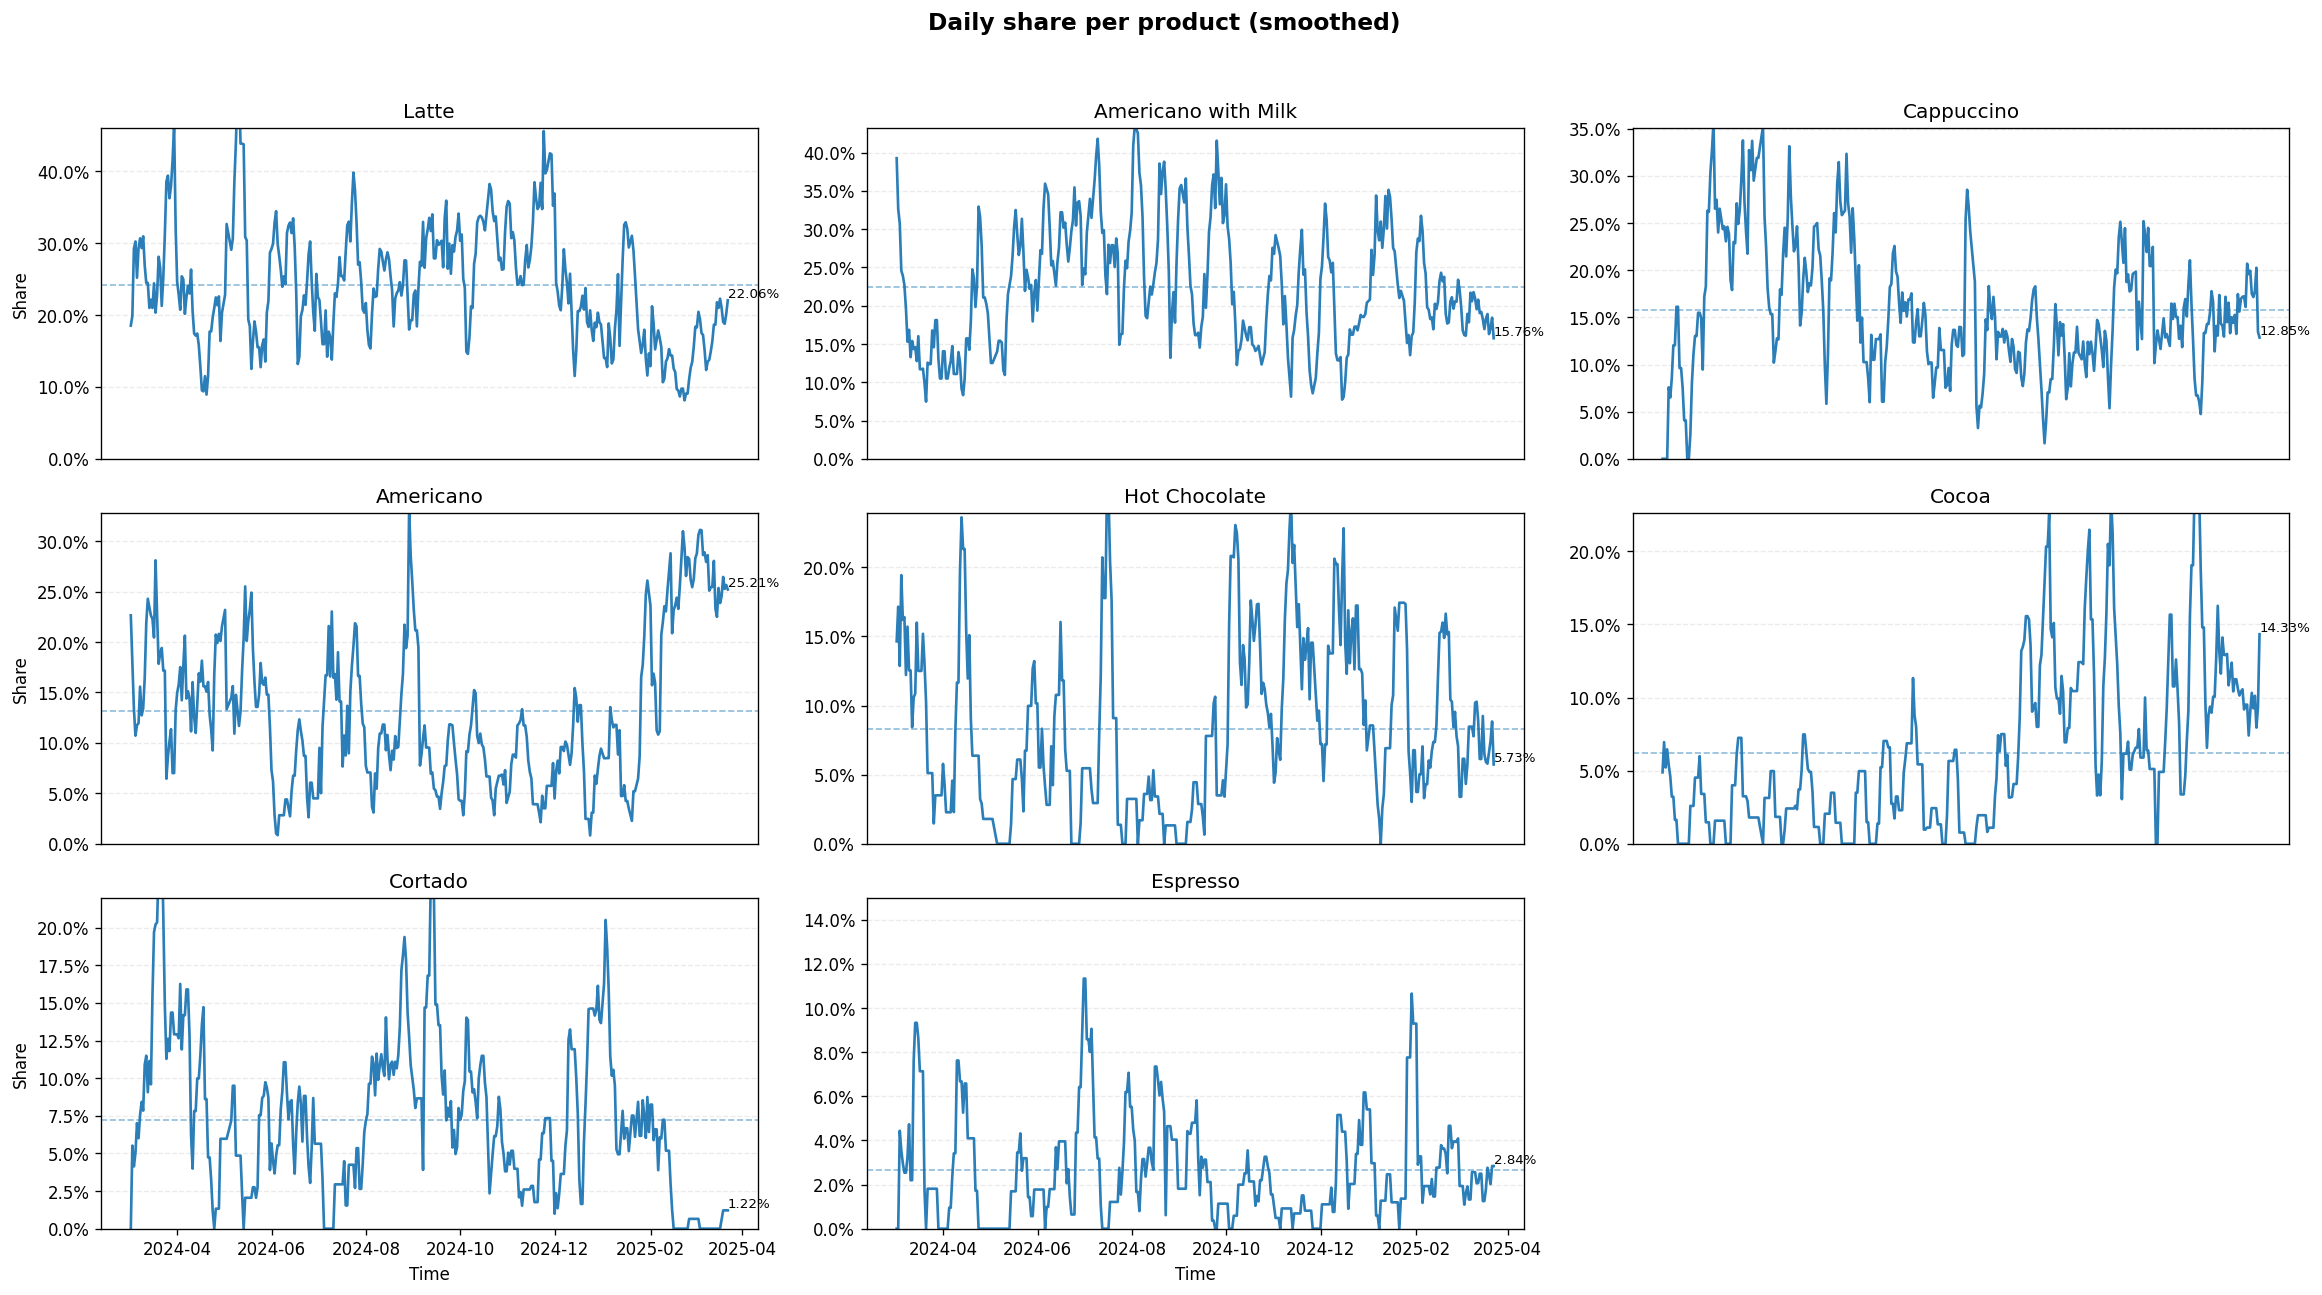

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from math import ceil

def plot_product_share_facets(
    df: pd.DataFrame,
    resample: str = "D",
    top_n: int = 12,
    cols: int = 3,
    smooth_window: int = 7,
    title: str | None = None,
    # --- nuevos parámetros de legibilidad/tamaño ---
    width_per_col: float = 6.0,
    height_per_row: float = 3.4,
    percent_decimals: int = 1,
    share_ylim: tuple | str | None = "auto",   # "auto" | (low, high) | None->(0,1)
    show_mean_line: bool = True,
):
    d = ensure_dt_local(df).set_index("dt_local")
    y = _pick_series_col(d)
    if PROD_COL not in d.columns:
        raise KeyError(f"Missing product column: {PROD_COL}")

    g = (
        d.groupby([pd.Grouper(freq=str(resample).upper()), PROD_COL], observed=False)[y]
         .sum()
         .unstack(fill_value=0)
    )
    tot = g.sum(axis=1).replace(0, np.nan)
    share = g.div(tot, axis=0)

    order = g.sum(axis=0).sort_values(ascending=False).index[:top_n]
    share = share[order]
    prods = list(share.columns)
    if not prods:
        print("No products.")
        return

    rows = ceil(len(prods) / cols)
    fig, axes = plt.subplots(
        rows, cols,
        figsize=(cols * width_per_col, rows * height_per_row),
        squeeze=False
    )

    for i, p in enumerate(prods):
        ax = axes[i // cols, i % cols]
        s = share[p].copy()

        # suavizado opcional
        if isinstance(smooth_window, int) and smooth_window and smooth_window > 1:
            s = s.rolling(window=smooth_window, min_periods=max(1, smooth_window // 3)).mean()

        ax.plot(s.index, s.values, linewidth=1.6, alpha=0.95)
        ax.set_title(str(p))

        # Y en porcentaje
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=percent_decimals))

        # Rango Y
        if share_ylim == "auto":
            # zoom por panel: usa p95 con margen; asegura mínimo 0.15 para no “aplastar”
            v = s.to_numpy(dtype=float)
            if np.isfinite(v).any():
                upper = float(np.nanpercentile(v, 97)) * 1.15
                upper = min(max(upper, 0.15), 1.0)
            else:
                upper = 1.0
            ax.set_ylim(0.0, upper)
        elif isinstance(share_ylim, tuple):
            ax.set_ylim(*share_ylim)
        else:
            ax.set_ylim(0.0, 1.0)

        # Línea de media de todo el período
        if show_mean_line:
            m = float(np.nanmean(share[p].to_numpy(dtype=float)))
            ax.axhline(m, linestyle="--", linewidth=1.0, alpha=0.5)
            # opcional: etiqueta sutil al final
            ax.text(s.index[-1], m, "", va="bottom", ha="right")

        # etiqueta del último valor
        last_idx = s.last_valid_index()
        if last_idx is not None:
            val = float(s.loc[last_idx])
            ax.text(last_idx, val, f"{val:.{percent_decimals+1}%}",
                    fontsize=8, ha="left", va="bottom")

        # grid ligero
        ax.grid(True, axis="y", linestyle="--", alpha=0.25)

        # ejes: solo izquierda y última fila muestran labels
        if i % cols != 0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel("Share")
        if i // cols != rows - 1:
            ax.set_xlabel("")
            ax.xaxis.set_major_locator(mtick.NullLocator())
        else:
            ax.set_xlabel("Time")
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    # eliminar ejes vacíos
    for j in range(len(prods), rows * cols):
        fig.delaxes(axes[j // cols, j % cols])

    if title:
        fig.suptitle(title, y=0.995, fontsize=14, fontweight="bold")

    fig.tight_layout(rect=(0, 0, 1, 0.97 if title else 1))
    plt.show()


plot_product_share_facets(
    df,
    resample="D",
    top_n=9,
    cols=3,
    smooth_window=7,
    title="Daily share per product (smoothed)",
    width_per_col=6.5,
    height_per_row=3.6,
    percent_decimals=1,
    share_ylim="auto",          # si quieres comparar exactamente, pon (0.0, 1.0)
    show_mean_line=True
)

## 7. External Sources

In [13]:
# ------------------------------
# External data fetcher (clean)
# ------------------------------
import json
import urllib.parse as uparse
import urllib.request as ureq
from typing import Iterable

import pandas as pd


class ExternalDataFetcher:
    """Descarga clima horario (Open-Meteo) y festivos (Nager.Date) y los fusiona con tus series."""

    def __init__(self, cfg: ProjectConfig, user_agent: str = "sales-ts-prep/1.0"):
        self.cfg = cfg
        self.ua = user_agent

    # ---------- utils ----------
    def _get_json(self, base_url: str, params: dict | None = None) -> dict:
        """HTTP GET que devuelve JSON, con errores claros."""
        url = f"{base_url}?{uparse.urlencode(params)}" if params else base_url
        req = ureq.Request(url, headers={"User-Agent": self.ua})
        try:
            with ureq.urlopen(req, timeout=60) as resp:
                data = resp.read().decode("utf-8")
            return json.loads(data)
        except Exception as exc:
            raise RuntimeError(f"GET failed for {url}: {exc}") from exc

    def _ensure_zoned_hour(self, s: pd.Series, tz: str) -> pd.Series:
        """
        Devuelve serie tz-aware alineada a la hora exacta en 'tz',
        redondeando SIEMPRE en UTC para evitar AmbiguousTimeError/DST.
        """
        dt = pd.to_datetime(s, errors="coerce")
        if not isinstance(dt.dtype, pd.DatetimeTZDtype):  # naive -> localiza
            dt = dt.dt.tz_localize(tz, nonexistent="shift_forward", ambiguous="NaT")
        else:  # aware -> convierte
            dt = dt.dt.tz_convert(tz)
        dt_utc = dt.dt.tz_convert("UTC").dt.floor("h")
        return dt_utc.dt.tz_convert(tz)

    # ---------- Open-Meteo (weather) ----------
    def fetch_weather_hourly(
        self,
        start_date: str,
        end_date: str,
        variables: Iterable[str] | None = None,
    ) -> pd.DataFrame:
        """Tiempo horario en UTC, convertido y alineado a la hora local del proyecto."""
        if variables is None:
            variables = ("temperature_2m", "relative_humidity_2m", "precipitation", "cloud_cover")

        params = {
            "latitude": self.cfg.latitude,
            "longitude": self.cfg.longitude,
            "start_date": str(start_date),
            "end_date": str(end_date),
            "hourly": ",".join(variables),
            "timezone": "UTC",
        }
        payload = self._get_json("https://archive-api.open-meteo.com/v1/archive", params)

        if "hourly" not in payload or "time" not in payload["hourly"]:
            cols = ["dt_local", *variables]
            return pd.DataFrame(columns=cols)

        df = pd.DataFrame(payload["hourly"]).rename(columns={"time": "dt_utc"})
        df["dt_utc"] = pd.to_datetime(df["dt_utc"], utc=True, errors="coerce")
        df = df.dropna(subset=["dt_utc"])

        # Floor en UTC y luego convertir a tz local (evita ambigüedades DST)
        df["dt_local"] = df["dt_utc"].dt.floor("h").dt.tz_convert(self.cfg.timezone)
        df = df.drop(columns=["dt_utc"])

        for v in variables:
            if v in df.columns:
                df[v] = pd.to_numeric(df[v], errors="coerce")

        cols = ["dt_local", *(v for v in variables if v in df.columns)]
        return df[cols].sort_values("dt_local").reset_index(drop=True)

    # ---------- Nager.Date (holidays) ----------
    def fetch_public_holidays(self, year: int) -> pd.DataFrame:
        """Festivos del país (y opcionalmente regiones) para un año."""
        url = f"https://date.nager.at/api/v3/PublicHolidays/{int(year)}/{self.cfg.country_code}"
        items = self._get_json(url)
        if not items:
            return pd.DataFrame(columns=["date", "is_holiday", "holiday_name"])

        df = pd.DataFrame(items)
        df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
        df = df.dropna(subset=["date"])

        if self.cfg.region_codes and "counties" in df.columns:
            df["counties"] = df["counties"].apply(lambda x: x or [])
            allowed = set(self.cfg.region_codes)
            df = df[df["counties"].apply(lambda lst: any(r in allowed for r in lst) or len(lst) == 0)]

        df["is_holiday"] = True
        df["holiday_name"] = df["localName"].astype(str)
        return df[["date", "is_holiday", "holiday_name"]]

    # ---------- merges sobre agregados (si los usas) ----------
    def merge_weather_hourly(self, hourly_df: pd.DataFrame, dt_col: str = "datetime") -> pd.DataFrame:
        """Left-join de tiempo horario a ventas horarias (por dt_col)."""
        if hourly_df.empty:
            return hourly_df.copy()

        tmp = hourly_df.copy()
        tmp[dt_col] = self._ensure_zoned_hour(tmp[dt_col], self.cfg.timezone)

        start_date = tmp[dt_col].min().date()
        end_date = tmp[dt_col].max().date()
        wx = self.fetch_weather_hourly(start_date, end_date)
        if wx.empty:
            return tmp

        # Normaliza clave de right y prefija columnas climáticas
        wx["_dt_hour"] = self._ensure_zoned_hour(wx["dt_local"], self.cfg.timezone)
        wx = wx.rename(columns={c: f"wx_{c}" for c in wx.columns if c not in {"dt_local", "_dt_hour"}})

        out = tmp.merge(wx, left_on=dt_col, right_on="_dt_hour", how="left")
        return out.drop(columns=["_dt_hour", "dt_local"], errors="ignore")

    def merge_holidays_daily(self, daily_df: pd.DataFrame, dt_col: str = "datetime") -> pd.DataFrame:
        """Left-join de festivos a serie diaria (por fecha local)."""
        if daily_df.empty:
            return daily_df.copy()

        tmp = daily_df.copy()
        dt = self._ensure_zoned_hour(tmp[dt_col], self.cfg.timezone)
        tmp["date"] = dt.dt.date

        years = sorted({d.year for d in tmp["date"]})
        frames = [self.fetch_public_holidays(y) for y in years]
        hol = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(columns=["date", "is_holiday", "holiday_name"])

        out = tmp.merge(hol, on="date", how="left")
        out["is_holiday"] = out["is_holiday"].astype("boolean").fillna(False)
        return out


# ---------------------------------------
# Enriquecimiento del DF original (raw)
# ---------------------------------------
import numpy as np
import pandas as pd

def enrich_raw_with_exogenous(
    df: pd.DataFrame,
    fetcher: ExternalDataFetcher,
    dt_col: str = "datetime",
    weather_vars: list[str] | None = None,
    add_weather: bool = True,
    add_holidays: bool = True,
    keep_holiday_date: bool = False,
) -> pd.DataFrame:
    """
    Enriquece el DF ORIGINAL con clima horario y festivos.
    - Clima: left-join por hora local (_dt_hour).
    - Festivos: left-join por fecha local (_date_local).
    No muta el DF de entrada.
    """
    if dt_col not in df.columns:
        raise KeyError(f"Missing datetime column: {dt_col}")

    cfg = fetcher.cfg
    out = df.copy()

    # Claves temporales locales, usando UTC para el floor (DST-safe)
    out["_dt_hour"] = fetcher._ensure_zoned_hour(out[dt_col], cfg.timezone)
    out["_date_local"] = out["_dt_hour"].dt.date

    # WEATHER HOURLY
    if add_weather:
        start_date = out["_dt_hour"].min().date()
        end_date = out["_dt_hour"].max().date()
        wx = fetcher.fetch_weather_hourly(start_date, end_date, variables=weather_vars)
        if not wx.empty:
            wx["_dt_hour"] = fetcher._ensure_zoned_hour(wx["dt_local"], cfg.timezone)
            wx = wx.rename(columns={c: f"wx_{c}" for c in wx.columns if c not in {"dt_local", "_dt_hour"}})
            out = out.merge(wx, on="_dt_hour", how="left")

    # HOLIDAYS DAILY
    if add_holidays:
        years = sorted({d.year for d in out["_date_local"]})
        frames = [fetcher.fetch_public_holidays(y) for y in years]
        if frames:
            hol = pd.concat(frames, ignore_index=True)
            hol = hol.rename(columns={"date": "holiday_date"})
            out = out.merge(hol, left_on="_date_local", right_on="holiday_date", how="left")
            out["is_holiday"] = out["is_holiday"].astype("boolean").fillna(False)
            if not keep_holiday_date:
                out = out.drop(columns=["holiday_date"])

    # Limpieza de auxiliares
    out = out.drop(columns=["_dt_hour"])
    # Si no quieres exponer _date_local, descomenta:
    # out = out.drop(columns=["_date_local"])

    return out

In [14]:
# Crear una instancia del objeto que descarga y combina datos externos (clima y festivos)
fetcher = ExternalDataFetcher(PROJ)

# Enriquecer el DataFrame original con datos exógenos (variables climáticas y festivos)
df_enriched = enrich_raw_with_exogenous(
    df,                              # DataFrame base con la serie de datos original
    fetcher,                         # Objeto que obtiene y prepara los datos externos
    dt_col="datetime",               # Nombre de la columna que contiene la fecha y hora
    weather_vars=[                   # Lista de variables climáticas que se van a agregar
        "temperature_2m",            # Temperatura del aire a 2 metros sobre el suelo (°C)
        "apparent_temperature",      # Sensación térmica calculada (°C)
        "dew_point_2m",              # Temperatura de punto de rocío a 2 metros (°C)
        "relative_humidity_2m",      # Humedad relativa a 2 metros (%)
        "pressure_msl",              # Presión atmosférica a nivel del mar (hPa)
        "precipitation",             # Precipitación total (mm)
        "rain",                      # Precipitación líquida (lluvia) (mm)
        "cloudcover",                # Porcentaje de nubosidad (%)
        "windspeed_10m",             # Velocidad del viento a 10 metros (km/h o m/s según API)
        "windgusts_10m"              # Rachas máximas de viento a 10 metros (km/h o m/s según API)
    ],
    add_weather=True,                # Incluir las variables climáticas seleccionadas
    add_holidays=True,               # Incluir indicador de festivos en las fechas
    keep_holiday_date=False          # No conservar la fecha exacta del festivo, solo el indicador
)

# Mostrar las primeras filas del DataFrame enriquecido para ver el resultado
df_enriched.head()

,date,datetime,cash_type,card,money,coffee_name,year,month,day,hour,...,wx_dew_point_2m,wx_relative_humidity_2m,wx_pressure_msl,wx_precipitation,wx_rain,wx_cloudcover,wx_windspeed_10m,wx_windgusts_10m,is_holiday,holiday_name
0,2024-03-01,2024-03-01 12:15:50.520000+02:00,card,ANON-0000-0000-0001,38.7,Latte,2024,3,1,12,...,1.5,61,1023.9,0.0,0.0,75,12.5,26.6,False,NaN
1,2024-03-01,2024-03-01 14:19:22.539000+02:00,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,14,...,2.1,59,1022.7,0.0,0.0,68,13.7,28.1,False,NaN
2,2024-03-01,2024-03-01 14:20:18.089000+02:00,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,14,...,2.1,59,1022.7,0.0,0.0,68,13.7,28.1,False,NaN
3,2024-03-01,2024-03-01 15:46:33.006000+02:00,card,ANON-0000-0000-0003,28.9,Americano,2024,3,1,15,...,0.5,55,1022.9,0.0,0.0,51,14.2,27.7,False,NaN
4,2024-03-01,2024-03-01 15:48:14.626000+02:00,card,ANON-0000-0000-0004,38.7,Latte,2024,3,1,15,...,0.5,55,1022.9,0.0,0.0,51,14.2,27.7,False,NaN


## 8. Export and final quality check

In [15]:
import re
import math
import pandas as pd
import numpy as np

def validate_df_enriched(df: pd.DataFrame) -> pd.DataFrame:
    """
    Valida esquema y contenido de df_enriched.
    Retorna un DataFrame con: column, check, status, details, sample_bad_values.
    """

    report = []  # acumulador del reporte

    def add_result(col: str, check: str, ok: bool, details: str, bad_vals=None):
        # Muestra pequeña de valores problemáticos
        sample = None
        if bad_vals is not None and len(bad_vals) > 0:
            sample = pd.Series(bad_vals).drop_duplicates().astype(str).head(5).tolist()
        report.append({
            "column": col,
            "check": check,
            "status": "OK" if ok else "FAIL",
            "details": details if ok else f"Problem found: {details}",
            "sample_bad_values": sample
        })

    # 1) Presencia de columnas
    expected_cols = [
        'date','datetime','cash_type','card','money','coffee_name','year','month','day','hour',
        'dow','week','month_sin','month_cos','hour_sin','hour_cos','_date_local','dt_local',
        'wx_temperature_2m','wx_apparent_temperature','wx_dew_point_2m','wx_relative_humidity_2m',
        'wx_pressure_msl','wx_precipitation','wx_rain','wx_cloudcover','wx_windspeed_10m',
        'wx_windgusts_10m','is_holiday','holiday_name'
    ]
    missing = [c for c in expected_cols if c not in df.columns]
    add_result("__all__", "columns_present", len(missing) == 0,
               "All expected columns present" if len(missing) == 0 else f"Missing columns: {missing}")

    # 2) Chequeos de tipo y formato

    numeric_cols_float = [
        'money','month_sin','month_cos','hour_sin','hour_cos',
        'wx_temperature_2m','wx_apparent_temperature','wx_dew_point_2m',
        'wx_pressure_msl','wx_precipitation','wx_rain',
        'wx_windspeed_10m','wx_windgusts_10m'
    ]
    numeric_cols_int = ['year','month','day','hour','dow','week','wx_relative_humidity_2m','wx_cloudcover']

    # Fechas en ISO YYYY-MM-DD
    for col in ['date','_date_local']:
        if col in df:
            s = df[col].astype(str)
            ok_mask = s.str.contains(r"^\d{4}-\d{2}-\d{2}$", regex=True, na=False)
            bad = s[~ok_mask].head(10).tolist()
            add_result(col, "iso_date_string", ok_mask.all(), "YYYY-MM-DD format", bad)

    # datetime y dt_local con zona horaria (sin warnings por grupos)
    # Ejemplos válidos: 2024-03-01 12:00:00+02:00, 2024-03-01T12:00:00.520000+02:00, ...Z
    datetime_pattern = r"^\d{4}-\d{2}-\d{2}[ T]\d{2}:\d{2}:\d{2}(?:\.\d+)?(?:[+-]\d{2}:\d{2}|Z)$"
    for col in ['datetime','dt_local']:
        if col in df:
            s = df[col].astype(str)
            ok_mask = s.str.contains(datetime_pattern, regex=True, na=False)
            bad = s[~ok_mask].head(10).tolist()
            add_result(col, "iso_datetime_with_tz", ok_mask.all(), "ISO datetime with timezone", bad)

    # cash_type en {cash, card}
    if 'cash_type' in df:
        allowed = {"cash","card"}
        s = df['cash_type'].astype(str)
        ok_mask = s.isin(allowed) | s.isna()
        bad = s[~ok_mask].head(10).tolist()
        add_result('cash_type', "allowed_values", ok_mask.all(), f"Allowed: {sorted(allowed)}", bad)

    # card anonimizada ANON-XXXX-XXXX-XXXX o vacío/NaN
    if 'card' in df:
        s = df['card'].astype(str)
        pattern = re.compile(r"^(?:ANON-[A-Z0-9]{4}-[A-Z0-9]{4}-[A-Z0-9]{4}|NaN|None|nan|\s*)$")
        bad_idx = ~s.apply(lambda x: bool(pattern.match(x)))
        add_result('card', "anonymized_pattern",
                   (~bad_idx).all(),
                   "Matches ANON-0000-0000-0000 or empty when not applicable",
                   s[bad_idx].head(10).tolist())

    # money numérica no negativa
    if 'money' in df:
        s = pd.to_numeric(df['money'], errors='coerce')
        ok_mask = s.notna() & (s >= 0)
        add_result('money', "numeric_non_negative", ok_mask.all(), ">= 0", df.loc[~ok_mask, 'money'].head(10).tolist())

    # Enteros
    for col in numeric_cols_int:
        if col in df:
            s = pd.to_numeric(df[col], errors='coerce')
            ok_mask = s.notna() & (s % 1 == 0)
            add_result(col, "integer_like", ok_mask.all(), "All integer-like values", df.loc[~ok_mask, col].head(10).tolist())

    # Flotantes
    for col in numeric_cols_float:
        if col in df:
            s = pd.to_numeric(df[col], errors='coerce')
            ok_mask = s.notna()
            add_result(col, "numeric", ok_mask.all(), "All numeric", df.loc[~ok_mask, col].head(10).tolist())

    # 3) Rangos y coherencias
    ranges = {
        'month': (1, 12),
        'day': (1, 31),
        'hour': (0, 23),
        'dow': (0, 6),
        'week': (1, 53),
        'wx_relative_humidity_2m': (0, 100),
        'wx_cloudcover': (0, 100)
    }
    for col, (lo, hi) in ranges.items():
        if col in df:
            s = pd.to_numeric(df[col], errors='coerce')
            ok_mask = s.notna() & (s >= lo) & (s <= hi)
            add_result(col, "value_range", ok_mask.all(), f"In [{lo}, {hi}]", df.loc[~ok_mask, col].head(10).tolist())

    # Trig en [-1, 1]
    for col in ['month_sin','month_cos','hour_sin','hour_cos']:
        if col in df:
            s = pd.to_numeric(df[col], errors='coerce')
            ok_mask = s.notna() & np.isfinite(s) & (s >= -1.0000001) & (s <= 1.0000001)
            add_result(col, "trig_range", ok_mask.all(), "In [-1, 1]", df.loc[~ok_mask, col].head(10).tolist())

    # --- reemplaza el bloque de consistencia de month_sin/cos por este ---
    if set(['month','month_sin','month_cos']).issubset(df.columns):
        month = pd.to_numeric(df['month'], errors='coerce')
        ms = pd.to_numeric(df['month_sin'], errors='coerce')
        mc = pd.to_numeric(df['month_cos'], errors='coerce')
        tol = 1e-6

        # Convención A: angle = 2π*(month-1)/12
        angle_a = 2 * math.pi * (month - 1) / 12
        sin_a = np.sin(angle_a)
        cos_a = np.cos(angle_a)

        # Convención B: angle = 2π*month/12
        angle_b = 2 * math.pi * month / 12
        sin_b = np.sin(angle_b)
        cos_b = np.cos(angle_b)

        ok_sin = ((np.abs(ms - sin_a) <= tol) | (np.abs(ms - sin_b) <= tol) | month.isna())
        ok_cos = ((np.abs(mc - cos_a) <= tol) | (np.abs(mc - cos_b) <= tol) | month.isna())

        add_result('month_sin', "consistency_with_month", ok_sin.all(),
                "Coincide con sin(2π*(m-1)/12) o sin(2π*m/12)",
                df.loc[~ok_sin, 'month_sin'].head(10).tolist())

        add_result('month_cos', "consistency_with_month", ok_cos.all(),
                "Coincide con cos(2π*(m-1)/12) o cos(2π*m/12)",
                df.loc[~ok_cos, 'month_cos'].head(10).tolist())


    # hour_sin/cos consistentes con hour
    if set(['hour','hour_sin','hour_cos']).issubset(df.columns):
        hour = pd.to_numeric(df['hour'], errors='coerce')
        angle = 2 * math.pi * hour / 24
        exp_sin = np.sin(angle)
        exp_cos = np.cos(angle)
        tol = 1e-6
        hs_ok = (np.abs(pd.to_numeric(df['hour_sin'], errors='coerce') - exp_sin) <= tol) | hour.isna()
        hc_ok = (np.abs(pd.to_numeric(df['hour_cos'], errors='coerce') - exp_cos) <= tol) | hour.isna()
        add_result('hour_sin', "consistency_with_hour", hs_ok.all(), "Matches sin(2π*hour/24)", df.loc[~hs_ok, 'hour_sin'].head(10).tolist())
        add_result('hour_cos', "consistency_with_hour", hc_ok.all(), "Matches cos(2π*hour/24)", df.loc[~hc_ok, 'hour_cos'].head(10).tolist())

    # dt_local alineado a la hora exacta
    if 'dt_local' in df:
        s = df['dt_local'].astype(str)
        # HH:00:00(.000)? + offset o Z
        ok_mask = s.str.contains(r"\d{2}:00:00(?:\.0+)?(?:[+-]\d{2}:\d{2}|Z)$", regex=True, na=False)
        add_result('dt_local', "hour_floor_alignment", ok_mask.all(), "Minutes and seconds are zero", s[~ok_mask].head(10).tolist())

    # datetime con offset/Z
    if 'datetime' in df:
        s = df['datetime'].astype(str)
        ok_mask = s.str.contains(r"(?:[+-]\d{2}:\d{2}|Z)$", regex=True, na=False)
        add_result('datetime', "timezone_aware", ok_mask.all(), "Has timezone offset or Z", s[~ok_mask].head(10).tolist())

    # Meteo plausibilidad física amplia
    ranges_soft = {
        'wx_temperature_2m': (-60, 60),
        'wx_apparent_temperature': (-80, 70),
        'wx_dew_point_2m': (-80, 40),
        'wx_pressure_msl': (850, 1100),
        'wx_precipitation': (0, 500),
        'wx_rain': (0, 500),
        'wx_windspeed_10m': (0, 200),
        'wx_windgusts_10m': (0, 250)
    }
    for col, (lo, hi) in ranges_soft.items():
        if col in df:
            s = pd.to_numeric(df[col], errors='coerce')
            ok_mask = s.notna() & (s >= lo) & (s <= hi)
            add_result(col, "physical_plausibility", ok_mask.all(), f"In [{lo}, {hi}] (wide)", df.loc[~ok_mask, col].head(10).tolist())

    # Precipitación no negativa y rain <= precipitation
    if set(['wx_precipitation','wx_rain']).issubset(df.columns):
        p = pd.to_numeric(df['wx_precipitation'], errors='coerce')
        r = pd.to_numeric(df['wx_rain'], errors='coerce')
        nonneg_mask = (p >= 0) & (r >= 0)
        leq_mask = r <= p
        add_result('wx_precipitation', "non_negative", nonneg_mask.fillna(True).all(), ">= 0", df.loc[~nonneg_mask, 'wx_precipitation'].head(10).tolist())
        add_result('wx_rain', "non_negative", nonneg_mask.fillna(True).all(), ">= 0", df.loc[~nonneg_mask, 'wx_rain'].head(10).tolist())

        # Construcción segura de muestra de pares problemáticos
        bad_pairs = df.loc[~leq_mask, ['wx_rain','wx_precipitation']].head(10)
        if not bad_pairs.empty:
            pair_list = bad_pairs.astype(str).apply(lambda r: ' | '.join(r.tolist()), axis=1).to_list()
        else:
            pair_list = []
        add_result('wx_rain', "rain_leq_total_precip", leq_mask.fillna(True).all(), "rain <= precipitation", pair_list)

    # is_holiday boolean y holiday_name coherente
    if 'is_holiday' in df:
        s = df['is_holiday']
        ok_bool = s.dropna().map(lambda x: isinstance(x, (bool, np.bool_))).all()
        bad_vals = df.loc[~s.dropna().map(lambda x: isinstance(x, (bool, np.bool_))), 'is_holiday'].head(10).tolist() if not ok_bool else None
        add_result('is_holiday', "boolean_type", ok_bool, "Boolean values", bad_vals)

    # --- reemplaza el bloque de consistencia de festivos por este ---
    if set(['is_holiday','holiday_name']).issubset(df.columns):
        # normalizar presencia de nombre SIN convertir NaN a 'nan'
        name_raw = df['holiday_name']
        # convertir a string manteniendo NA como NA
        name_str = name_raw.astype('string')
        # limpiar espacios y bajar a minúsculas para detectar placeholders
        name_clean = name_str.str.strip().str.lower()
        # considerar vacío si es NA o "", "nan", "none", "null"
        has_name = name_clean.notna() & ~name_clean.isin({'', 'nan', 'none', 'null'})

        mask_false_with_name = (df['is_holiday'] == False) & has_name
        mask_true_without_name = (df['is_holiday'] == True) & ~has_name

        bad_rows = df.loc[mask_false_with_name | mask_true_without_name, ['is_holiday','holiday_name']].head(10)
        bad_list = bad_rows.astype(str).apply(lambda r: ' | '.join(r.tolist()), axis=1).to_list() if not bad_rows.empty else []

        add_result(
            'holiday_name',
            "consistency_with_is_holiday",
            (~mask_false_with_name & ~mask_true_without_name).all(),
            "Nombre presente solo cuando is_holiday=True",
            bad_list
        )


    # coffee_name no vacío
    if 'coffee_name' in df:
        s = df['coffee_name'].astype(str)
        ok_mask = s.str.len().gt(0)
        add_result('coffee_name', "non_empty", ok_mask.all(), "Non-empty strings", s[~ok_mask].head(10).tolist())

    rep_df = pd.DataFrame(report).sort_values(
        by=["status", "column", "check"],
        ascending=[True, True, True]
    ).reset_index(drop=True)

    return rep_df

In [16]:
quality_report = validate_df_enriched(df_enriched)
# Ver primeros hallazgos problemáticos
quality_report[quality_report["status"] == "FAIL"]

,column,check,status,details,sample_bad_values


In [17]:
df_enriched.to_csv(PATHS.clean_csv_path, index = False)

In [22]:
data_dict = {
    "date": "Fecha de la transacción (YYYY-MM-DD)",
    "datetime": "Fecha y hora exacta de la transacción con zona horaria",
    "cash_type": "Método de pago (efectivo o tarjeta)",
    "card": "Identificador anonimizado de la tarjeta",
    "money": "Monto pagado en la transacción",
    "coffee_name": "Nombre del producto de café vendido",
    "year": "Año de la transacción (entero)",
    "month": "Mes de la transacción (1-12)",
    "day": "Día del mes (1-31)",
    "hour": "Hora del día (0-23)",
    "dow": "Día de la semana (0=lunes, 6=domingo)",
    "week": "Número de semana del año",
    "month_sin": "Transformación seno del mes (para estacionalidad)",
    "month_cos": "Transformación coseno del mes (para estacionalidad)",
    "hour_sin": "Transformación seno de la hora (para estacionalidad horaria)",
    "hour_cos": "Transformación coseno de la hora (para estacionalidad horaria)",
    "_date_local": "Fecha local sin información horaria",
    "dt_local": "Fecha y hora local redondeada a la hora",
    "wx_temperature_2m": "Temperatura del aire a 2 m sobre el suelo (°C)",
    "wx_apparent_temperature": "Sensación térmica calculada (°C)",
    "wx_dew_point_2m": "Punto de rocío a 2 m sobre el suelo (°C)",
    "wx_relative_humidity_2m": "Humedad relativa a 2 m (%)",
    "wx_pressure_msl": "Presión atmosférica a nivel del mar (hPa)",
    "wx_precipitation": "Precipitación total (mm)",
    "wx_rain": "Precipitación líquida (lluvia) (mm)",
    "wx_cloudcover": "Cobertura de nubes (%)",
    "wx_windspeed_10m": "Velocidad del viento a 10 m (km/h o m/s según API)",
    "wx_windgusts_10m": "Rachas máximas de viento a 10 m (km/h o m/s según API)",
    "is_holiday": "Indicador de si la fecha es festiva (True/False)",
    "holiday_name": "Nombre del festivo (si aplica)"
}

data_dict_df = (pd.DataFrame([data_dict]).T)

data_dict_df.reset_index().to_csv(PATHS.data_dict_path, index = False)

In [19]:
export_to_pdf = True

if export_to_pdf:
    import os
    os.environ["PATH"] = r"C:\Program Files\Pandoc;C:\Program Files\MiKTeX\miktex\bin\x64;" + os.environ["PATH"]

    import shutil
    print(shutil.which("pandoc"))
    print(shutil.which("pdflatex"))

    !jupyter nbconvert --to pdf coffee_vending_eda.ipynb

C:\Program Files\Pandoc\pandoc.EXE
C:\Program Files\MiKTeX\miktex\bin\x64\pdflatex.EXE


[NbConvertApp] Converting notebook coffee_vending_eda.ipynb to pdf
[NbConvertApp] Support files will be in coffee_vending_eda_files\
[NbConvertApp] Making directory .\coffee_vending_eda_files
[NbConvertApp] Writing 236327 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1309505 bytes to coffee_vending_eda.pdf


In [20]:
#END